In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

# Загрузка данных

In [ ]:
from coursework_1.download_data import load_data
load_data()

Скачиваем архив с данными...
Скачиваем веса модели...
Распаковываем архив...
Готово!


In [2]:
import os
import random
import torch
import matplotlib
import cv2

import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from sklearn.preprocessing import MinMaxScaler
from skimage.transform import rotate
from skimage.util import montage
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from coursework_1.config import *

In [ ]:
print(f"Device: {DEVICE}")

Device: cuda


In [6]:
# Была ошибка с названием файла
old_name = os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_355", "W39_1998.09.19_Segm.nii")
new_name = os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_355", "BraTS20_Training_355_seg.nii")


try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully!")
except:
    print("File is already renamed!")

File is already renamed!


# EDA

In [7]:
# Посмотрим на примере одного пациента
example_image_flair = nib.load(TRAIN_DATASET_PATH / "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
example_image_t1 = nib.load(TRAIN_DATASET_PATH / 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
example_image_t1ce = nib.load(TRAIN_DATASET_PATH / 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
example_image_t2 = nib.load(TRAIN_DATASET_PATH / 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
example_image_mask = nib.load(TRAIN_DATASET_PATH / 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

In [8]:
print(f"Flair shape: {example_image_flair.shape}")
print(f"T1 shape: {example_image_t1.shape}")
print(f"T1ce shape: {example_image_t1ce.shape}")
print(f"T2 shape: {example_image_t2.shape}")
print(f"Mask shape: {example_image_mask.shape}")

Flair shape: (240, 240, 155)
T1 shape: (240, 240, 155)
T1ce shape: (240, 240, 155)
T2 shape: (240, 240, 155)
Mask shape: (240, 240, 155)


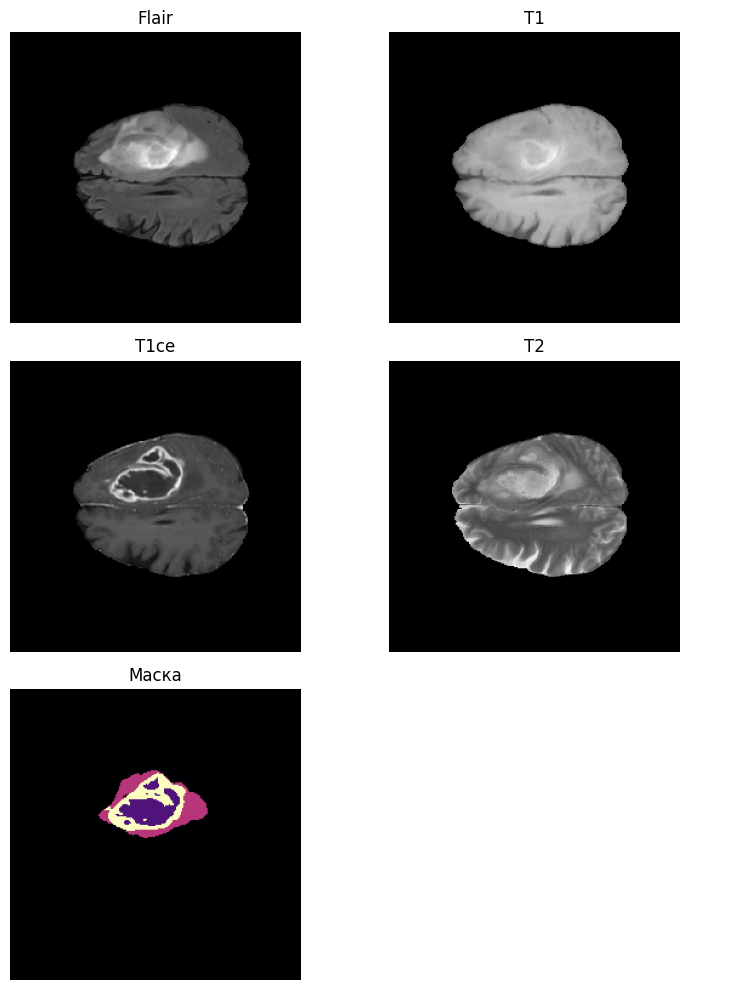

In [9]:
part = 100
fig, ax = plt.subplots(3, 2, figsize=(8,10))
ax = ax.flatten()

ax[0].imshow(example_image_flair[:,:, part], cmap='gray')
ax[0].set_axis_off()
ax[0].set_title("Flair")

ax[1].imshow(example_image_t1[:,:, part], cmap='gray')
ax[1].set_axis_off()
ax[1].set_title("T1")

ax[2].imshow(example_image_t1ce[:,:, part], cmap='gray')
ax[2].set_axis_off()
ax[2].set_title("T1ce")

ax[3].imshow(example_image_t2[:,:, part], cmap='gray')
ax[3].set_axis_off()
ax[3].set_title("T2")

ax[4].imshow(example_image_mask[:,:, part], cmap='magma')
ax[4].set_axis_off()
ax[4].set_title("Маска")

ax[5].set_axis_off()
plt.tight_layout()
plt.show()

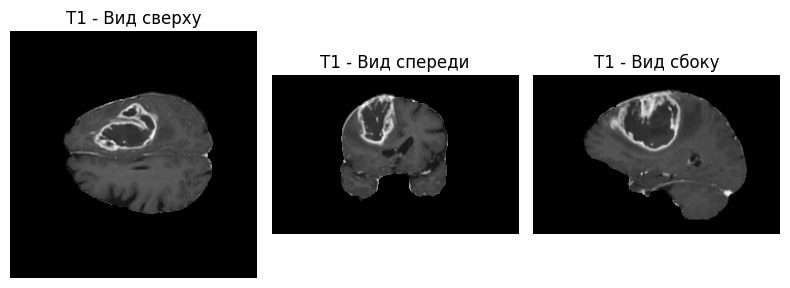

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(8, 10))
ax = ax.flatten()

ax[0].imshow(example_image_t1ce[:, :, part], cmap='gray')
ax[0].set_axis_off()
ax[0].set_title('T1 - Вид сверху')

ax[1].imshow(rotate(example_image_t1ce[:, part, :], 90, resize=True), cmap='gray')
ax[1].set_axis_off()
ax[1].set_title('T1 - Вид спереди')

ax[2].imshow(rotate(example_image_t1ce[part, :, :], 90, resize=True), cmap='gray')
ax[2].set_axis_off()
ax[2].set_title('T1 - Вид сбоку')

plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(3119.5), np.float64(3119.5), np.float64(-0.5))

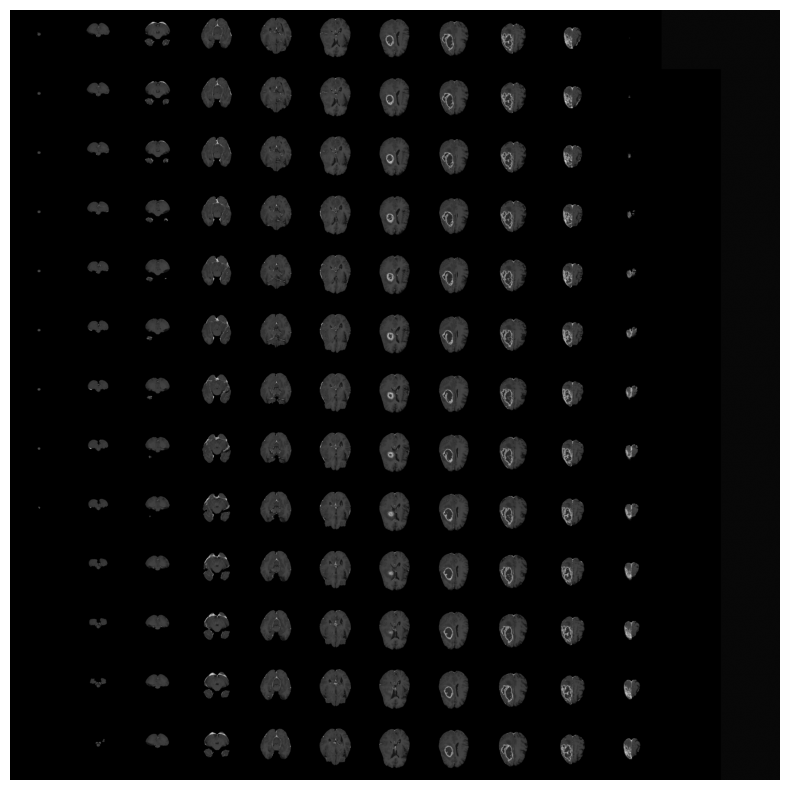

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

coronal = montage(example_image_t1ce[:, :, :].transpose(2, 0, 1))
plt.imshow(rotate(coronal, 90, resize=True), cmap='gray')
plt.axis("off")

(np.float64(-0.5), np.float64(3119.5), np.float64(3119.5), np.float64(-0.5))

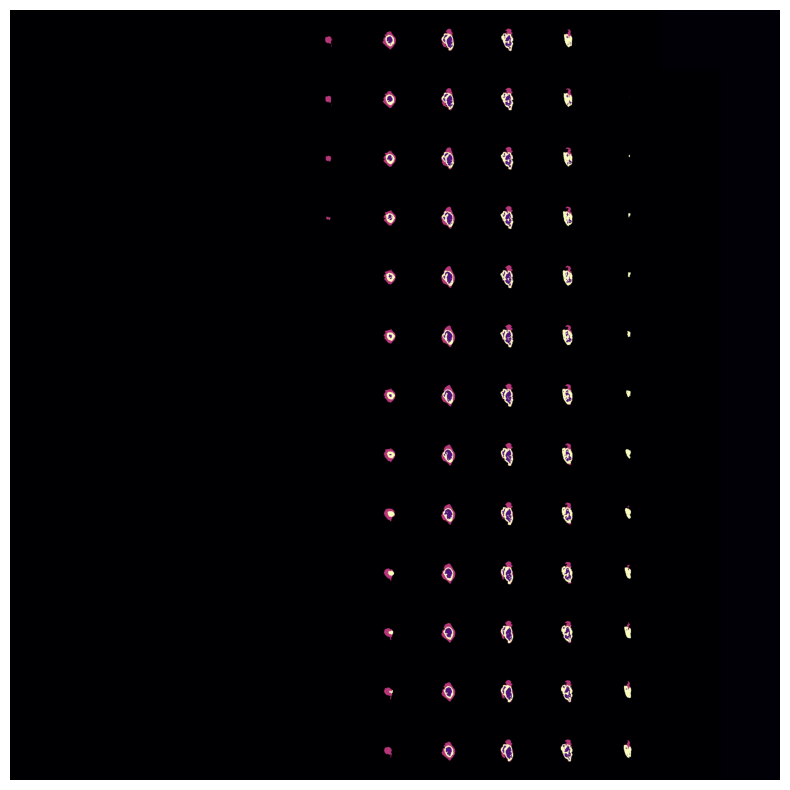

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

coronal = montage(example_image_mask[:, :, :].transpose(2, 0, 1))
plt.imshow(rotate(coronal, 90, resize=True), cmap='magma')
plt.axis("off")

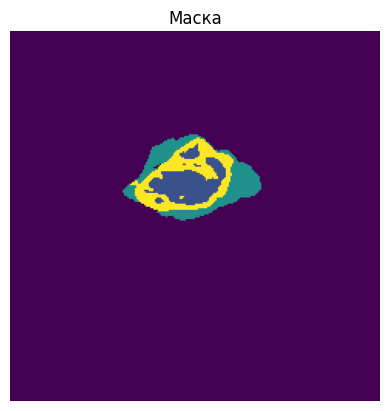

In [13]:
plt.imshow(example_image_mask[:,:,part])
plt.axis('off')
plt.title("Маска")
plt.show()

In [14]:
mask = example_image_mask[:, :, part]
class0_mask = mask.copy()
class0_mask[mask != 0] = np.nan

class1_mask = mask.copy()
class1_mask[mask != 1] = np.nan

class2_mask = mask.copy()
class2_mask[mask != 2] = np.nan

class3_mask = mask.copy()
class3_mask[mask != 3] = np.nan

class4_mask = mask.copy()
class4_mask[mask != 4] = np.nan

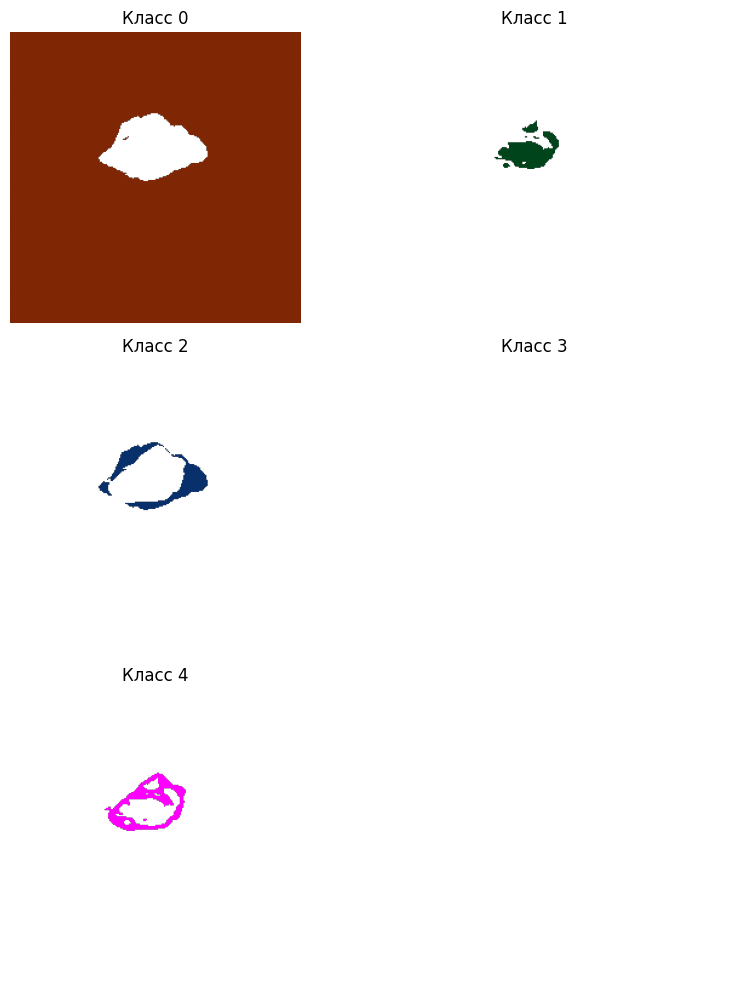

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
ax = ax.flatten()

cmaps = ['Oranges_r', 'Greens_r', 'Blues_r', 'Reds_r', "cool_r"]

masks = [class0_mask, class1_mask, class2_mask, class3_mask, class4_mask]
for i in range(5):
    ax[i].imshow(masks[i], cmap=cmaps[i])
    ax[i].set_title(f'Класс {i}')
    ax[i].axis('off')

ax[5].set_axis_off()

plt.tight_layout()
plt.show()

3 класс не фигурирует в данных. Заменим 4 на 3.

# Dataset для данных

In [16]:
from coursework_1.dataset import split_data

train_data, val_data, test_data = split_data()

In [17]:
print(f"Train data length: {len(train_data)}")
print(f"Validation data length: {len(val_data)}")
print(f"Test data length: {len(test_data)}")

Train data length: 250
Validation data length: 74
Test data length: 45


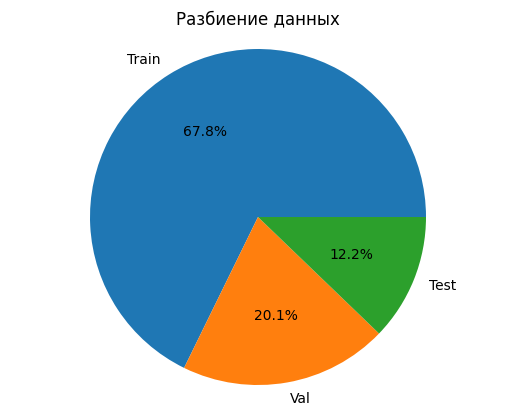

In [18]:
sizes = [len(train_data), len(val_data), len(test_data)]
labels = ['Train', 'Val', 'Test']

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title("Разбиение данных")
plt.show()

In [19]:
from coursework_1.dataset import get_dataloaders


train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
                                                        train_data,\
                                                        val_data,\
                                                        test_data
                                                    )

In [20]:
from models import UNet

unet_model = UNet(N_CHANNELS, NUM_CLASSES)
unet_model.to(DEVICE)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [22]:
num_parameters = sum([p.numel() for p in unet_model.parameters() if p.requires_grad])
print(f"У модели {num_parameters} параметра")

У модели 31037252 параметра


Epoch 1/35 - Train: 100%|██████████| 1563/1563 [32:09<00:00,  1.23s/it]


Train - loss: 0.2881, IoU: 0.5114, Dice: 0.6188, Acc: 0.9940, Prec: 0.6797, Rec: 0.6346, F1: 0.6381


Epoch 1/35 - Val: 100%|██████████| 463/463 [08:38<00:00,  1.12s/it]


Val   - loss: 0.2498, IoU: 0.5551, Dice: 0.6715, Acc: 0.9952, Prec: 0.7885, Rec: 0.6317, F1: 0.6814
Model saved with val_loss = 0.2498


Epoch 2/35 - Train: 100%|██████████| 1563/1563 [32:15<00:00,  1.24s/it]


Train - loss: 0.1891, IoU: 0.6314, Dice: 0.7474, Acc: 0.9963, Prec: 0.7932, Rec: 0.7504, F1: 0.7583


Epoch 2/35 - Val: 100%|██████████| 463/463 [08:35<00:00,  1.11s/it]


Val   - loss: 0.2331, IoU: 0.5717, Dice: 0.6898, Acc: 0.9946, Prec: 0.7193, Rec: 0.7301, F1: 0.7027
Model saved with val_loss = 0.2331


Epoch 3/35 - Train: 100%|██████████| 1563/1563 [32:31<00:00,  1.25s/it]


Train - loss: 0.1686, IoU: 0.6625, Dice: 0.7749, Acc: 0.9967, Prec: 0.8162, Rec: 0.7772, F1: 0.7854


Epoch 3/35 - Val: 100%|██████████| 463/463 [08:41<00:00,  1.13s/it]


Val   - loss: 0.1963, IoU: 0.6240, Dice: 0.7394, Acc: 0.9962, Prec: 0.7785, Rec: 0.7416, F1: 0.7494
Model saved with val_loss = 0.1963


Epoch 4/35 - Train: 100%|██████████| 1563/1563 [31:56<00:00,  1.23s/it]


Train - loss: 0.1512, IoU: 0.6897, Dice: 0.7980, Acc: 0.9970, Prec: 0.8354, Rec: 0.7995, F1: 0.8084


Epoch 4/35 - Val: 100%|██████████| 463/463 [08:31<00:00,  1.10s/it]


Val   - loss: 0.1963, IoU: 0.6237, Dice: 0.7383, Acc: 0.9959, Prec: 0.7864, Rec: 0.7415, F1: 0.7499
Model saved with val_loss = 0.1963


Epoch 5/35 - Train: 100%|██████████| 1563/1563 [31:48<00:00,  1.22s/it]


Train - loss: 0.1417, IoU: 0.7052, Dice: 0.8106, Acc: 0.9972, Prec: 0.8447, Rec: 0.8132, F1: 0.8211


Epoch 5/35 - Val: 100%|██████████| 463/463 [08:32<00:00,  1.11s/it]


Val   - loss: 0.1955, IoU: 0.6246, Dice: 0.7403, Acc: 0.9961, Prec: 0.7743, Rec: 0.7458, F1: 0.7490
Model saved with val_loss = 0.1955


Epoch 6/35 - Train: 100%|██████████| 1563/1563 [31:48<00:00,  1.22s/it]


Train - loss: 0.1345, IoU: 0.7175, Dice: 0.8201, Acc: 0.9973, Prec: 0.8525, Rec: 0.8233, F1: 0.8307


Epoch 6/35 - Val: 100%|██████████| 463/463 [08:30<00:00,  1.10s/it]


Val   - loss: 0.1908, IoU: 0.6335, Dice: 0.7483, Acc: 0.9964, Prec: 0.8306, Rec: 0.7180, F1: 0.7569
Model saved with val_loss = 0.1908


Epoch 7/35 - Train: 100%|██████████| 1563/1563 [31:52<00:00,  1.22s/it]


Train - loss: 0.1255, IoU: 0.7321, Dice: 0.8321, Acc: 0.9975, Prec: 0.8629, Rec: 0.8348, F1: 0.8425


Epoch 7/35 - Val: 100%|██████████| 463/463 [08:32<00:00,  1.11s/it]


Val   - loss: 0.1821, IoU: 0.6478, Dice: 0.7587, Acc: 0.9965, Prec: 0.8195, Rec: 0.7487, F1: 0.7670
Model saved with val_loss = 0.1821


Epoch 8/35 - Train: 100%|██████████| 1563/1563 [31:48<00:00,  1.22s/it]


Train - loss: 0.1202, IoU: 0.7413, Dice: 0.8392, Acc: 0.9976, Prec: 0.8681, Rec: 0.8419, F1: 0.8494


Epoch 8/35 - Val: 100%|██████████| 463/463 [08:32<00:00,  1.11s/it]


Val   - loss: 0.2007, IoU: 0.6218, Dice: 0.7348, Acc: 0.9960, Prec: 0.8168, Rec: 0.7204, F1: 0.7444


Epoch 9/35 - Train: 100%|██████████| 1563/1563 [31:49<00:00,  1.22s/it]


Train - loss: 0.1136, IoU: 0.7528, Dice: 0.8480, Acc: 0.9977, Prec: 0.8764, Rec: 0.8507, F1: 0.8584


Epoch 9/35 - Val: 100%|██████████| 463/463 [08:32<00:00,  1.11s/it]


Val   - loss: 0.1855, IoU: 0.6451, Dice: 0.7561, Acc: 0.9965, Prec: 0.8272, Rec: 0.7319, F1: 0.7645


Epoch 10/35 - Train: 100%|██████████| 1563/1563 [31:35<00:00,  1.21s/it]


Train - loss: 0.1101, IoU: 0.7593, Dice: 0.8525, Acc: 0.9978, Prec: 0.8801, Rec: 0.8551, F1: 0.8629


Epoch 10/35 - Val: 100%|██████████| 463/463 [08:24<00:00,  1.09s/it]


Val   - loss: 0.1975, IoU: 0.6273, Dice: 0.7393, Acc: 0.9963, Prec: 0.7995, Rec: 0.7255, F1: 0.7470


Epoch 11/35 - Train: 100%|██████████| 1563/1563 [31:34<00:00,  1.21s/it]


Train - loss: 0.0962, IoU: 0.7844, Dice: 0.8710, Acc: 0.9981, Prec: 0.8953, Rec: 0.8744, F1: 0.8819


Epoch 11/35 - Val: 100%|██████████| 463/463 [08:30<00:00,  1.10s/it]


Val   - loss: 0.1756, IoU: 0.6594, Dice: 0.7686, Acc: 0.9967, Prec: 0.8187, Rec: 0.7589, F1: 0.7770
Model saved with val_loss = 0.1756


Epoch 12/35 - Train: 100%|██████████| 1563/1563 [32:07<00:00,  1.23s/it]


Train - loss: 0.0921, IoU: 0.7919, Dice: 0.8765, Acc: 0.9981, Prec: 0.9007, Rec: 0.8799, F1: 0.8875


Epoch 12/35 - Val: 100%|██████████| 463/463 [08:36<00:00,  1.12s/it]


Val   - loss: 0.1766, IoU: 0.6576, Dice: 0.7669, Acc: 0.9966, Prec: 0.8186, Rec: 0.7578, F1: 0.7755


Epoch 13/35 - Train: 100%|██████████| 1563/1563 [32:03<00:00,  1.23s/it]


Train - loss: 0.0914, IoU: 0.7934, Dice: 0.8775, Acc: 0.9982, Prec: 0.9006, Rec: 0.8812, F1: 0.8883


Epoch 13/35 - Val: 100%|██████████| 463/463 [08:35<00:00,  1.11s/it]


Val   - loss: 0.1719, IoU: 0.6646, Dice: 0.7732, Acc: 0.9967, Prec: 0.8186, Rec: 0.7654, F1: 0.7816
Model saved with val_loss = 0.1719


Epoch 14/35 - Train: 100%|██████████| 1563/1563 [32:06<00:00,  1.23s/it]


Train - loss: 0.0891, IoU: 0.7979, Dice: 0.8805, Acc: 0.9982, Prec: 0.9035, Rec: 0.8844, F1: 0.8916


Epoch 14/35 - Val: 100%|██████████| 463/463 [08:37<00:00,  1.12s/it]


Val   - loss: 0.1762, IoU: 0.6589, Dice: 0.7679, Acc: 0.9966, Prec: 0.8185, Rec: 0.7578, F1: 0.7762


Epoch 15/35 - Train: 100%|██████████| 1563/1563 [32:10<00:00,  1.24s/it]


Train - loss: 0.0876, IoU: 0.8006, Dice: 0.8824, Acc: 0.9983, Prec: 0.9051, Rec: 0.8864, F1: 0.8935


Epoch 15/35 - Val: 100%|██████████| 463/463 [08:37<00:00,  1.12s/it]


Val   - loss: 0.1753, IoU: 0.6609, Dice: 0.7696, Acc: 0.9967, Prec: 0.8340, Rec: 0.7494, F1: 0.7780


Epoch 16/35 - Train: 100%|██████████| 1563/1563 [32:08<00:00,  1.23s/it]


Train - loss: 0.0859, IoU: 0.8037, Dice: 0.8848, Acc: 0.9983, Prec: 0.9071, Rec: 0.8891, F1: 0.8960


Epoch 16/35 - Val: 100%|██████████| 463/463 [08:36<00:00,  1.11s/it]


Val   - loss: 0.1751, IoU: 0.6615, Dice: 0.7698, Acc: 0.9967, Prec: 0.8270, Rec: 0.7552, F1: 0.7782


Epoch 17/35 - Train: 100%|██████████| 1563/1563 [32:05<00:00,  1.23s/it]


Train - loss: 0.0826, IoU: 0.8100, Dice: 0.8893, Acc: 0.9983, Prec: 0.9110, Rec: 0.8932, F1: 0.9005


Epoch 17/35 - Val: 100%|██████████| 463/463 [08:36<00:00,  1.12s/it]


Val   - loss: 0.1717, IoU: 0.6659, Dice: 0.7742, Acc: 0.9967, Prec: 0.8185, Rec: 0.7680, F1: 0.7826
Model saved with val_loss = 0.1717


Epoch 18/35 - Train: 100%|██████████| 1563/1563 [32:06<00:00,  1.23s/it]


Train - loss: 0.0826, IoU: 0.8101, Dice: 0.8891, Acc: 0.9984, Prec: 0.9112, Rec: 0.8936, F1: 0.9005


Epoch 18/35 - Val: 100%|██████████| 463/463 [08:36<00:00,  1.11s/it]


Val   - loss: 0.1750, IoU: 0.6614, Dice: 0.7701, Acc: 0.9967, Prec: 0.8202, Rec: 0.7597, F1: 0.7782


Epoch 19/35 - Train: 100%|██████████| 1563/1563 [32:08<00:00,  1.23s/it]


Train - loss: 0.0817, IoU: 0.8119, Dice: 0.8904, Acc: 0.9984, Prec: 0.9120, Rec: 0.8948, F1: 0.9018


Epoch 19/35 - Val: 100%|██████████| 463/463 [08:37<00:00,  1.12s/it]


Val   - loss: 0.1743, IoU: 0.6625, Dice: 0.7709, Acc: 0.9967, Prec: 0.8193, Rec: 0.7620, F1: 0.7792


Epoch 20/35 - Train: 100%|██████████| 1563/1563 [32:04<00:00,  1.23s/it]


Train - loss: 0.0814, IoU: 0.8125, Dice: 0.8908, Acc: 0.9984, Prec: 0.9123, Rec: 0.8957, F1: 0.9022


Epoch 20/35 - Val: 100%|██████████| 463/463 [08:37<00:00,  1.12s/it]


Val   - loss: 0.1734, IoU: 0.6638, Dice: 0.7721, Acc: 0.9967, Prec: 0.8191, Rec: 0.7640, F1: 0.7804


Epoch 21/35 - Train: 100%|██████████| 1563/1563 [32:10<00:00,  1.23s/it]


Train - loss: 0.0808, IoU: 0.8136, Dice: 0.8916, Acc: 0.9984, Prec: 0.9135, Rec: 0.8962, F1: 0.9031


Epoch 21/35 - Val: 100%|██████████| 463/463 [08:40<00:00,  1.12s/it]


Val   - loss: 0.1747, IoU: 0.6621, Dice: 0.7707, Acc: 0.9967, Prec: 0.8204, Rec: 0.7605, F1: 0.7788


Epoch 22/35 - Train: 100%|██████████| 1563/1563 [32:09<00:00,  1.23s/it]


Train - loss: 0.0810, IoU: 0.8135, Dice: 0.8913, Acc: 0.9984, Prec: 0.9129, Rec: 0.8959, F1: 0.9028


Epoch 22/35 - Val: 100%|██████████| 463/463 [08:37<00:00,  1.12s/it]

Val   - loss: 0.1740, IoU: 0.6629, Dice: 0.7716, Acc: 0.9967, Prec: 0.8185, Rec: 0.7629, F1: 0.7798
Early stopping triggered.


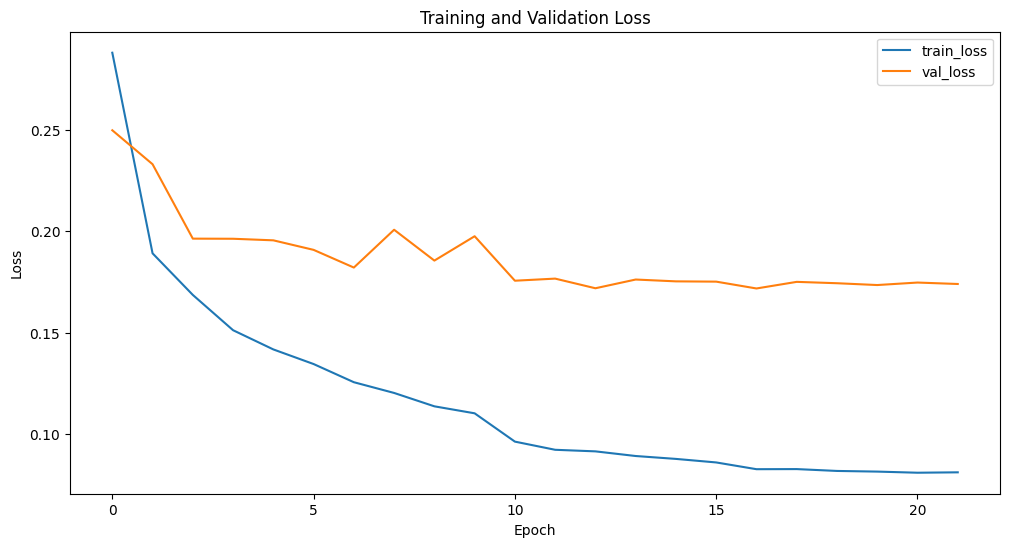

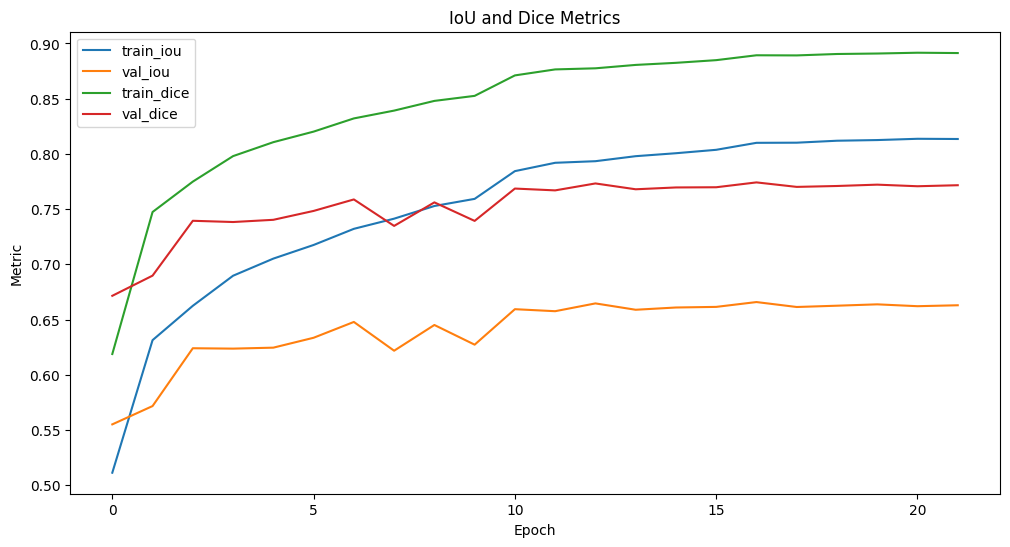

{'train_loss': [0.28808274788404226,
  0.18908877353292966,
  0.16856511133131277,
  0.15115224126242555,
  0.14167290837316276,
  0.13446155821121586,
  0.125491875845293,
  0.1201944499063858,
  0.1135955832645974,
  0.11014591725882779,
  0.09617573322200348,
  0.09214678129999972,
  0.09136913625269613,
  0.08907537951693653,
  0.08764632327466612,
  0.08590150296316265,
  0.08256971504794278,
  0.08261993945703168,
  0.08170711686947905,
  0.08138527983104808,
  0.08082944976782006,
  0.0810247980777987],
 'val_loss': [0.24981545227263968,
  0.23306426867746122,
  0.19633903824291785,
  0.19628009690901116,
  0.19550496190142683,
  0.19080090376329217,
  0.18207012213460827,
  0.20072656982532072,
  0.18550759925633734,
  0.19752272202373838,
  0.17557890534594042,
  0.17661399714503895,
  0.17185516269237897,
  0.17616131801970833,
  0.1752592393118671,
  0.17512186663325868,
  0.17174814614119335,
  0.1750110558055132,
  0.17433642166350882,
  0.17344169859366076,
  0.1746719331

In [ ]:
from coursework_1.modeling.losses import ComboLoss
from coursework_1.modeling.train import train

optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, min_lr=1e-6)
criterion = ComboLoss(alpha=0.3)

train(train_dataloader, val_dataloader, unet_model, criterion, optimizer, scheduler, num_epochs=35)

# Проверка модели на тестовых данных

In [ ]:
from coursework_1.modeling.predict import evaluate_model_on_test

evaluate_model_on_test(unet_model, test_dataloader)

100%|██████████| 282/282 [05:09<00:00,  1.10s/it]


==================== TEST REPORT ====================
Dice per class: [0.9982230067253113, 0.7715365886688232, 0.8256918787956238, 0.8481460809707642]
Dice mean: 0.8608994483947754
IoU per class: [0.9964523911476135, 0.6280501484870911, 0.7031304836273193, 0.7363312840461731]
IoU mean: 0.7659910321235657
Precision: 0.8780506253242493
Recall: 0.863998293876648
F1: 0.8706681132316589


100%|██████████| 282/282 [06:20<00:00,  1.35s/it]


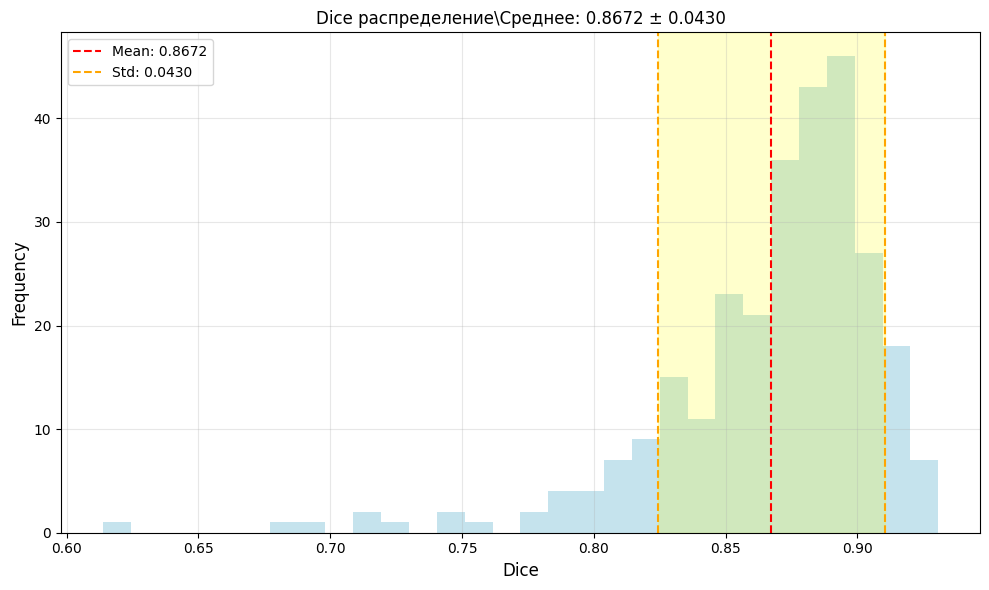

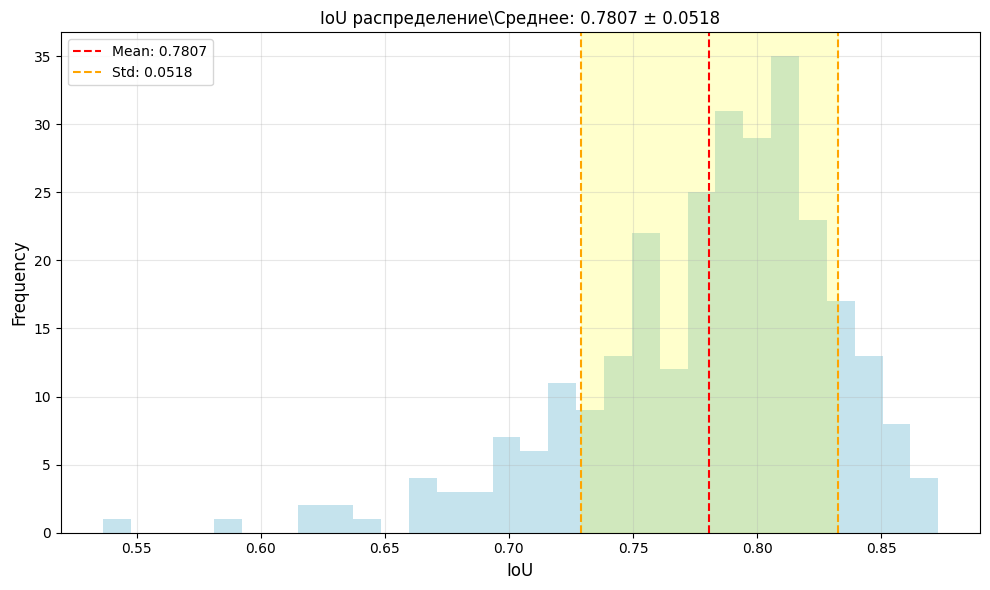

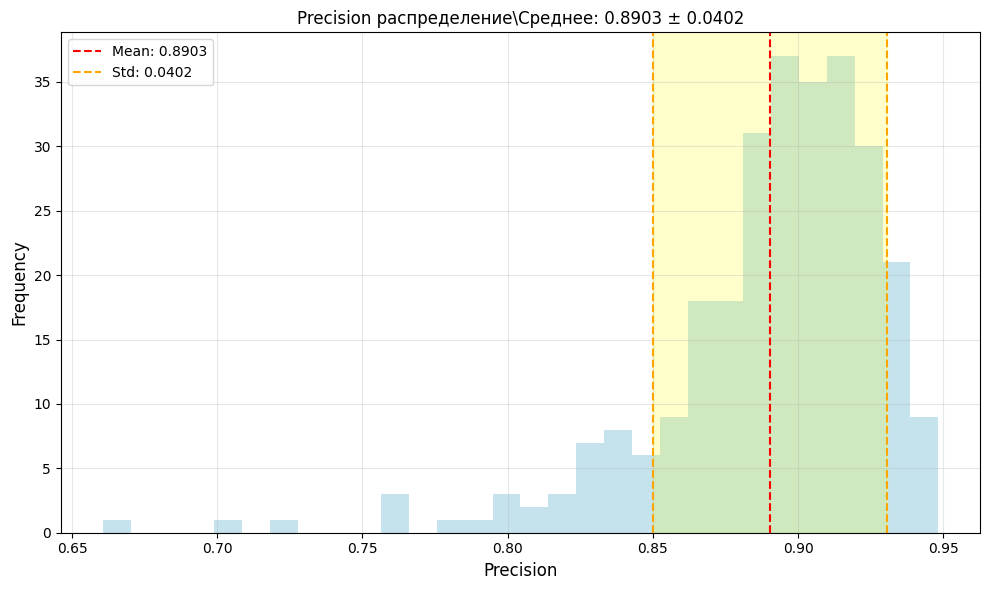

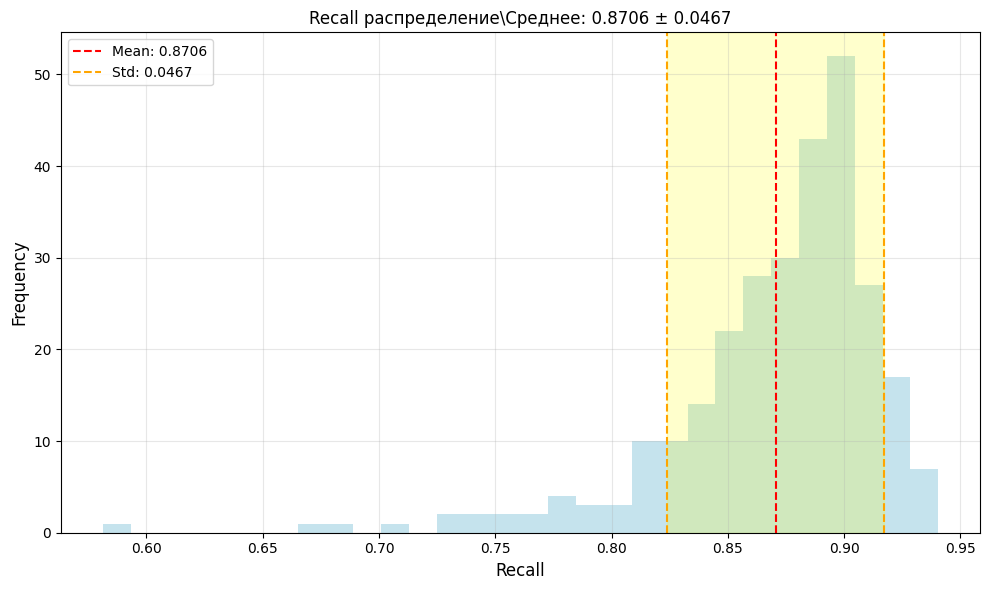

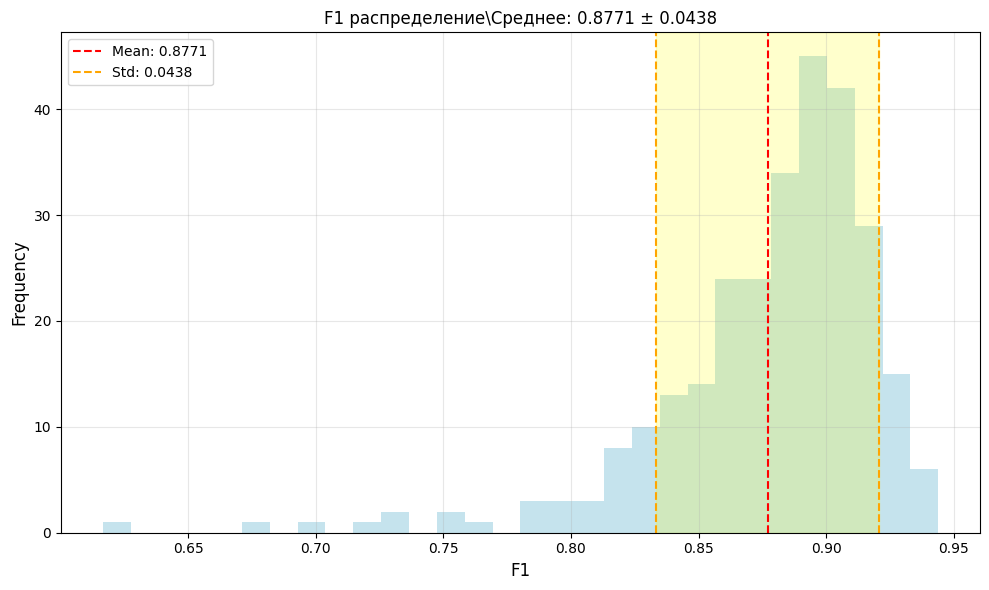

In [ ]:
from coursework_1.plots import plot_metrics

plot_metrics(unet_model, test_dataloader)

In [27]:
from coursework_1.plots import visualize_prediction
from coursework_1.dataset import get_dataset

test_dataset = get_dataset(test_data)

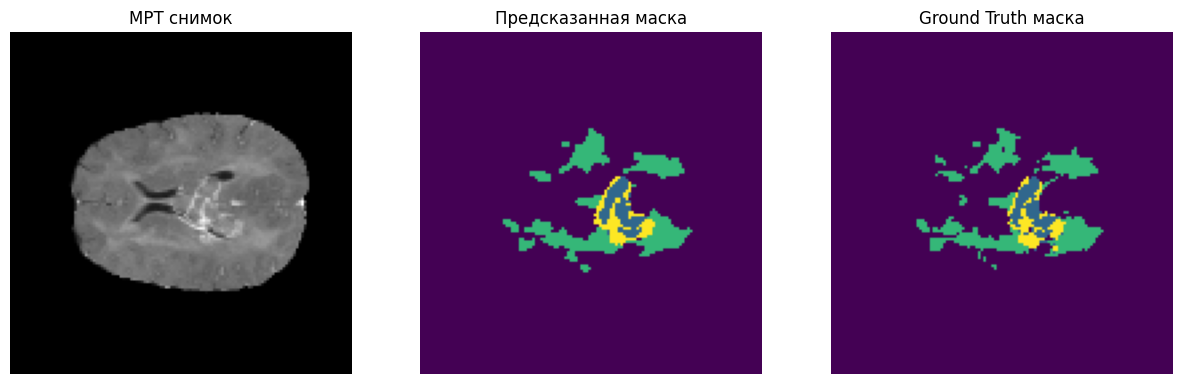

In [ ]:
visualize_prediction(unet_model, test_dataset)

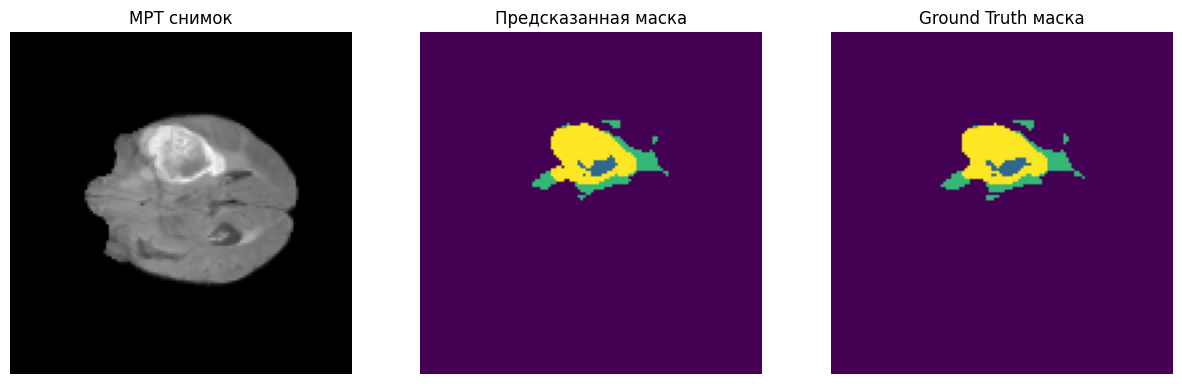

In [ ]:
visualize_prediction(unet_model, test_dataset)

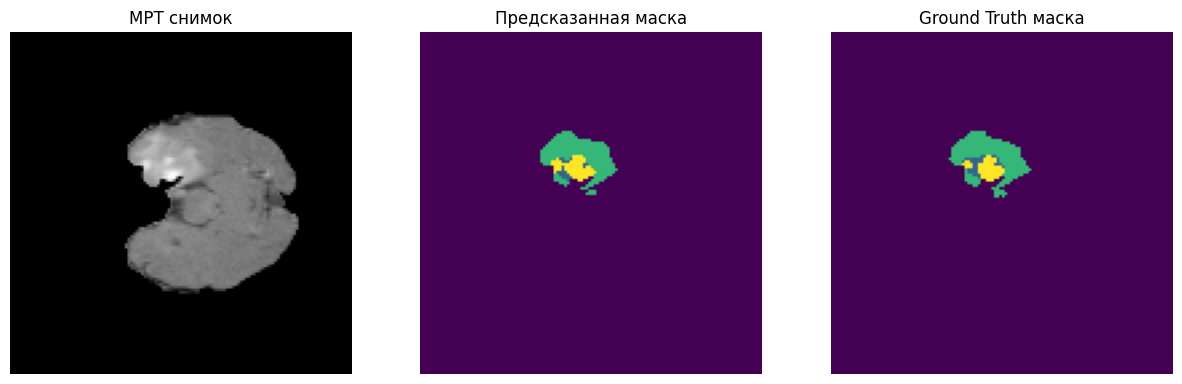

In [ ]:
visualize_prediction(unet_model, test_dataset)

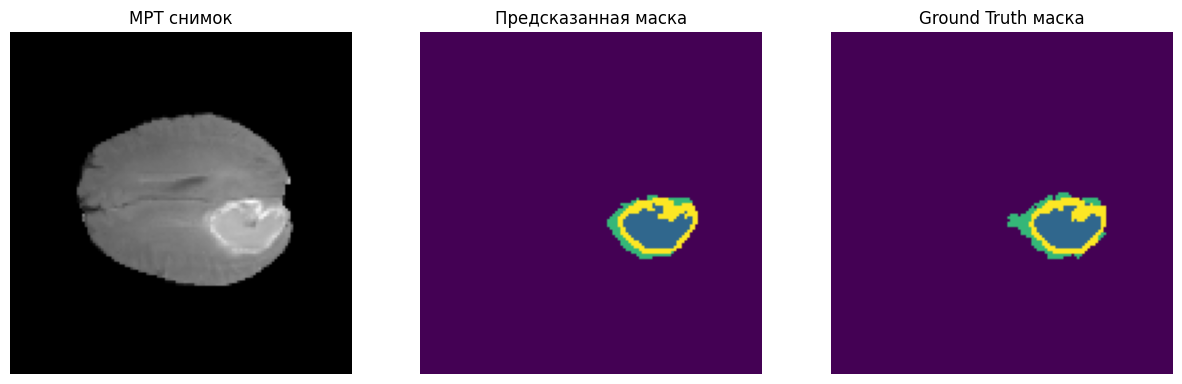

In [ ]:
visualize_prediction(unet_model, test_dataset)

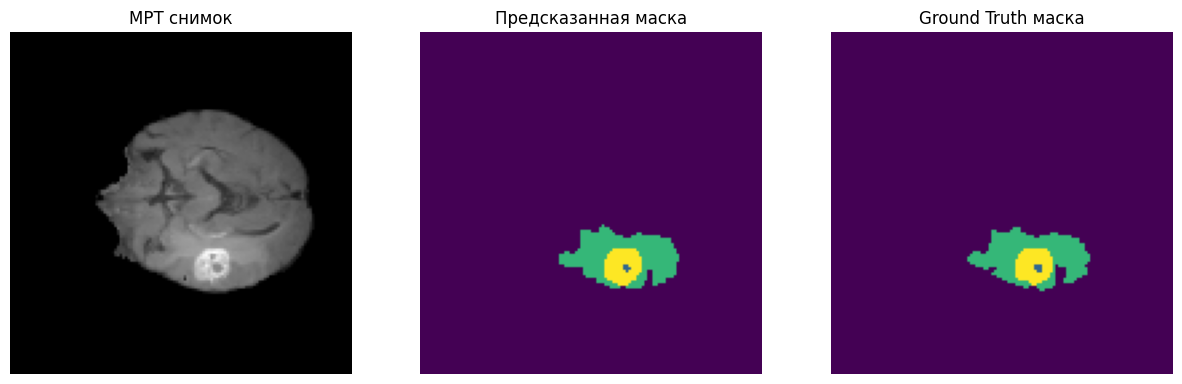

In [ ]:
visualize_prediction(unet_model, test_dataset)

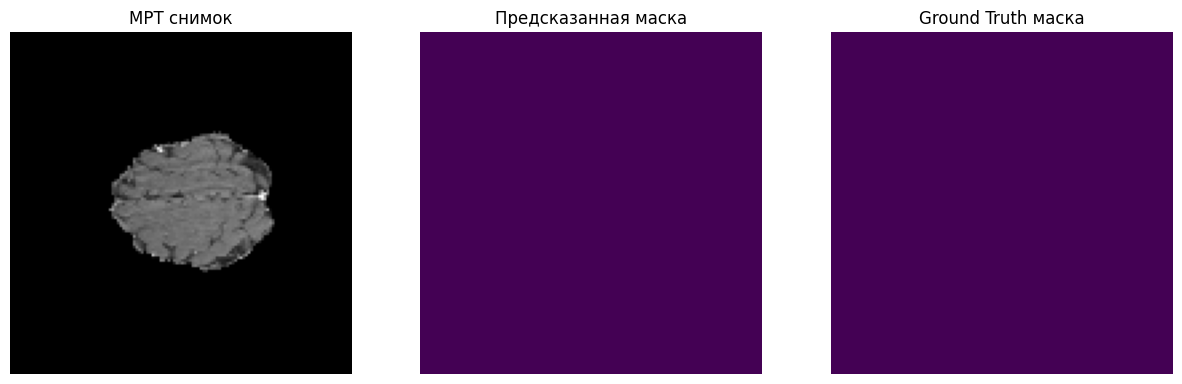

In [ ]:
visualize_prediction(unet_model, test_dataset)

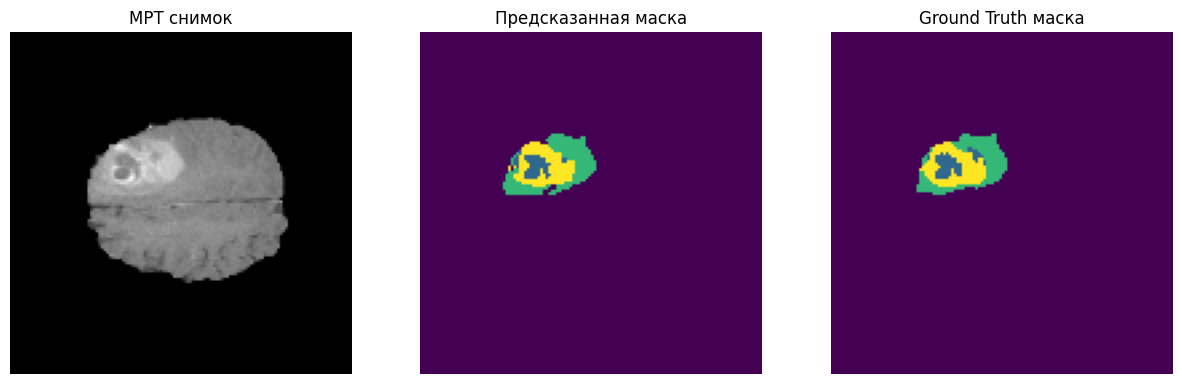

In [ ]:
visualize_prediction(unet_model, test_dataset)